# Mock Interview Answers

## Questions:
1. Given this dataset, how would you approach studying how interactive users are with this product?  What factors would you need to consider?  
    A: Could say to look at how many times per day a user logs in, how long they are logged in, or how often they click (clicks per unit time or click per login).  You might need to consider cases when a user logs in and forgets to log out, unintentional clicks, etc.

2. Let's focus on the case where we study how often a user clicks.  Can you write a function that takes in a username and software version, and returns clicks per (unit time)?

3. Run your function for each user and store each of their average number of clicks per (unit time).

4. How would you analyze which version of the software generates more user interaction?  Are you making any assumptions for this analysis?  
    A: Should use, e.g., a paired t-test.  Why?  Because these are the same set of users testing both versions!

5. Go ahead and perform this test.  Would you recommend the test build as an improvement over the original based on your analysis so far?  Why or why not?  
    A: Based on our results below, we should recommend the test version of the software because it has a p-value < 0.05.

6. Are there any caveats the team should know about your result?  
    A: Maybe this result shouldn't be used if it increases user interaction, but decreases the total number of users!  Maybe this increases the number of clicks but decreases the amount of time they spend using the product (another way of viewing "user engagement").  Lots of things need to be tested before a result like this one was put into production!

In [1]:
import pandas as pd
from user_info import save_users

In [2]:
# Generate a mock user dataset
save_users()

100%|███████████████████████████████████████████████████| 5089/5089 [00:03<00:00, 1509.22it/s]


## Read the data

These are a few simple initial checks of the data that the interviewee may or may not do to get a sense of what is in the file.

In [3]:
data = pd.read_csv('clickdata.csv', parse_dates=['timestamp'])

In [4]:
data

,UID,timestamp,msg,version
0,1107,2020-03-21 17:44:30,Login,test
1,1114,2020-03-21 17:54:21,Login,orig
2,9570,2020-03-21 17:57:52,Signal_Level_47,orig
3,5685,2020-03-21 18:02:59,Signal_Level_09,orig
4,9213,2020-03-21 18:08:57,Signal_Level_66,orig
...,...,...,...,...
85267,972,2021-03-21 22:42:16,Signal_Level_48,orig
85268,247,2021-03-21 23:11:39,Logout,test
85269,3298,2021-03-21 23:26:32,Signal_Level_64,orig
85270,2182,2021-03-21 23:42:55,record_click,test


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85272 entries, 0 to 85271
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   UID        85272 non-null  int64         
 1   timestamp  85272 non-null  datetime64[ns]
 2   msg        85272 non-null  object        
 3   version    85272 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.6+ MB


In [6]:
messages = data.msg.unique().astype(str)
# print(messages)
messages_important = [m for m in messages if m[:-2] != 'Signal_Level_']
print('Important messages: ', messages_important)

Important messages:  ['Login', 'record_click', 'Logout']


In [7]:
data.version.unique()

array(['test', 'orig'], dtype=object)

In [8]:
# Clean the data
clean_data = data[data.msg.isin(messages_important)]

## Click rate

In [9]:
def calc_clicks_per_day(data, uid, version):
    '''
    Assumes the same number of logins and logouts and
    that each logout follows a login.
    '''
    userdata = data[(data.UID == uid) & (data.version == version)]
    
    login_data = userdata[userdata.msg == 'Login']
    logout_data = userdata[userdata.msg == 'Logout']
    login_data.reset_index(inplace=True)
    logout_data.reset_index(inplace=True)
    
    time_logged_in = (logout_data.timestamp - login_data.timestamp).sum()
    
    clicks = (userdata.msg == 'record_click').sum()
    
    clickrate = clicks/(time_logged_in/pd.to_timedelta(1, unit='D'))
    return clickrate

In [10]:
calc_clicks_per_day(clean_data, 4985, 'orig')

19.909048396825504

## Comparing user click rates

In [11]:
users = clean_data.UID.unique()
print(f'{len(users)} users')

user_clicks_orig = [(u, calc_clicks_per_day(clean_data, u, 'orig')) for u in users]
user_clicks_test = [(u, calc_clicks_per_day(clean_data, u, 'test')) for u in users]
user_clicks_orig = pd.DataFrame(user_clicks_orig, columns = ['UID', 'avg_clicks'])
user_clicks_test = pd.DataFrame(user_clicks_test, columns = ['UID', 'avg_clicks'])

# np.array(
#     [calc_clicks_per_min(clean_data, u, 'orig') for u in users])
# user_clicks_test = np.array(
#     [calc_clicks_per_min(clean_data, u, 'test') for u in users])

955 users


Some diagnostic info:

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

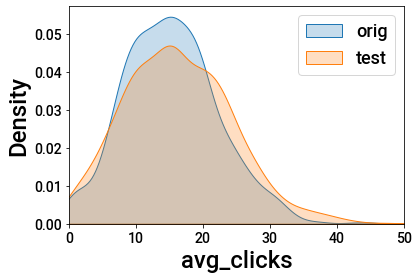

In [13]:
sns.kdeplot(user_clicks_orig.avg_clicks, shade=True, label='orig')
sns.kdeplot(user_clicks_test.avg_clicks, shade=True, label='test')
plt.xlim(0., 50.)
plt.legend()

In [14]:
print('Means:    ', user_clicks_orig.avg_clicks.mean(), user_clicks_test.avg_clicks.mean())
print('Std devs: ', user_clicks_orig.avg_clicks.std(), user_clicks_test.avg_clicks.std())

Means:     15.191579016448669 16.248554866782644
Std devs:  7.000313734637303 8.080006989540465


### One-sided paired t-test
`alternative='less'` below makes it one-sided (null hypothesis is that argument 1 is less than argument 2).



In [15]:
from scipy.stats import ttest_rel

In [16]:
results = ttest_rel(user_clicks_orig.avg_clicks, user_clicks_test.avg_clicks, alternative='less')
print(f't = {results.statistic}')
print(f'p value = {results.pvalue}')

t = -3.068678318363722
p value = 0.0011054126456494626


## Assumptions
- Logins precede logouts.
- The click rate uses the time between login and logout (rather than, e.g., the time between first and last click).
- Each user has used both the orig and test versions. (Otherwise, we would use an *unpaired* t-test.---I think this code mostly still works.)

## Recommendation

(Assuming that the click rate is actually a good metric for interactivity,) I would recommend the test build. The p-value is extremely small.